## Import libraries

In [ ]:
import os
import math
import json
import folium
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from scipy import stats
from vega_datasets import data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import cos, sin, arcsin, sqrt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import InterclusterDistance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.figure(figsize=(20,5))

PALETTE_DEG = ["FF"]
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12

In [ ]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
df['delta'] = (df.delivery_dt - df.delivery_effective).dt.total_seconds() / 3600

## Utils functions

In [ ]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def remove_outlayers(dataframe: pd.DataFrame, feature: str, complete=False):
  z_scores = stats.zscore(dataframe[feature])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = abs_z_scores < 3
  if complete:
    return dataframe[filtered_entries]
  return dataframe[ filtered_entries ][feature]


## Enmanuel Magallanes

## Question: Is the total size of packages a factor affecting the timeliness of deliveries?

In [ ]:
#dict of size
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }
color_scale = alt.Scale(domain=list(size_dict.values()))

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='total_size', order=size_dict.values(), palette=PALETTE)
set_labels('Frecuencia de los tipos de peso', 'Tipo de peso', 'Frecuencia')

In [ ]:
brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(data).mark_bar().encode(
  x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=40)), y='count()',
  color=alt.Color('Total size:N', scale=color_scale),
).properties(width=380, height=250)
background = base.encode(color=alt.value('#ddd')).add_selection(brush)

highlight = base.transform_filter(brush)
columns = ['total_size', 'distance', 'task_around']
data = df.sample(5000)[columns]
data.columns = ['Total size', 'Distance', 'Neighboring deliveries']
alt.layer(background, highlight, data=data).repeat(column=list(data.columns)[1:]).properties(title='Distance - Neighboring deliveries')

In [ ]:
gsl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gsl, x='total_size', y='id', hue='is_late', order=size_dict.values(), palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
diff_size = with_hue(f, list(size_dict.values()), 5, 2, diff=True)

In the graph we can see that there are more deliveries with size X Small and Medium than the others. However, what is important here is to analyze the percentage of tasks delivered on time and those that are not. There are no significant differences between Small and Small X-size tasks. In contrast, Medium, Large and X Large tasks have a significant difference in the percentage of on-time deliveries. This indicates that the size of deliverables affects on-time delivery when their size is equal to or larger than Medium.

In [ ]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_size, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by total size of delivery',
  x_label='Class of size of deliveries', y_label='Amount of deliveries'
)

## Question 2: Are tasks with fewer neighboring deliveries* taking longer to reach their delivery point?
\* We define neighboring deliveries as all those deliveries that are less than or equal to X KM away from the same and their delivery date is within T hours of the same.

In [ ]:
# We will group deliveries by route ID, to get the average distance and time from the first delivery to the last delivery. 
# With these values we will obtain distance and time ranges to find the route density.
def haversine_distance(x, y):
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * math.asin(sqrt(a))
  return R * c

def generate_combinations(points):
  combinations = []
  for i in range(len(points)):
    for j in range(i+1, len(points)):
      combinations.append([points[i], points[j]])
  return combinations

def calculate_time(group):
  min_dt = group['delivery_dt'].min()
  max_dt = group['delivery_dt'].max()
  return (max_dt - min_dt).total_seconds() / 3600

def calculate_distance(group):
  group = group.set_index('delivery_dt')
  group = group.sort_values('delivery_dt')
  center = (group['long'].mean(), group['lat'].mean())
  return np.array(group.apply(lambda r: haversine_distance((r.long, r.lat), center), axis=1)).mean()

gr_hours = df.groupby('route_id').apply(calculate_time)
gr_distance = df.groupby('route_id').apply(calculate_distance)

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of time from first to last delivery')
ax[0].set_xlabel('Time (hour)')
sns.kdeplot(data=gr_distance, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of time from first to last delivery')
ax[1].set_xlabel('Time (hour)')
sns.boxenplot(data=gr_distance, ax=ax[1], color=PALETTE[1])

print('Mean time from first delivery to the last delivery: {0:.2f} hours'.format(gr_hours.mean()))

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of distance from first to last delivery')
ax[0].set_xlabel('Distnace (km)')
sns.kdeplot(data=gr_hours, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of distance from first to last delivery')
ax[1].set_xlabel('Distnace (km)')
sns.boxenplot(data=gr_hours, ax=ax[1], color=PALETTE[1])
print('Mean distance first delivery to the last delivery: {0:.2f} km'.format(gr_distance.mean()))

As we can see the scheduled time from the first delivery to the last delivery, on average, is 3.12 hours and the distance, on average, is 3.20 km. These values will be our time window and radius to use to determine the number of deliveries that exist around one

In [ ]:
df['class_neighboring'] = pd.cut(
  df['task_around'], 
  include_lowest=True,
  bins=[x for x in range(0, 800, 100)]
)
#df_filtered['class_neighboring'] = df_filtered['class_neighboring'].astype('str')

In [ ]:
# Remoiving outlayers using the z-score
task_around_filtered = remove_outlayers(df, 'task_around')

fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of neighboring deliveries')
ax[0].set_xlabel('Neighboring deliveries')
sns.kdeplot(data=df_filtered['task_around'], ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of neighboring deliveries')
ax[1].set_xlabel('Neighboring deliveries')
sns.boxenplot(data=task_around_filtered, ax=ax[1], color=PALETTE[1])

print('Mean neighboring deliveries: {0:.2f} deliveries'.format(task_around_filtered.mean()))
print('STD neighboring deliveries: {0:.2f}'.format(task_around_filtered.std()))

In [ ]:
gnl = df_filtered[['id', 'class_neighboring', 'is_late']].groupby(['class_neighboring', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gnl, x='class_neighboring', y='id', hue='is_late', palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per class of neighboring deliverie', 'Bind of neighboring deliveries', 'Amount of deliveries', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
classes_list = list(map(lambda item: str(item), df_filtered['class_neighboring'].sort_values().unique()))
diff_list = with_hue(f, classes_list, 7, 2, diff=True)

In the plot we can see that as the number of neighboring deliveries increases, the percentage of late deliveries also increases. This tells us that the higher the concentration or density of deliveries around you, the more likely it is that you will be late in reaching the final customer

In [297]:
columns = ['total_size', 'distance', 'task_around', 'lat', 'long', 'delta', 'cost']
LAT_AXIS = alt.X('lat', type='quantitative', scale=alt.Scale(domain=(-33.70, -33.15)), title='Latitude')
LONG_AXIS = alt.Y('long',type='quantitative', scale=alt.Scale(domain=(-70.4, -70.9)), title='Longitude')
DEN_AXIS = y=alt.Y('density', type='quantitative', title='Density')

data = remove_outlayers(df.sample(5000)[columns], 'task_around', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1],).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data[columns]).transform_density(density="task_around", as_=['task_around', 'density'],).mark_area().encode(
  x=alt.X('task_around', type='quantitative', title='Neighboring deliveries'), y=DEN_AXIS
  #color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).properties(title='Location of delivery by Neighborign deliveries')

alt.HConcatChart(...)

In [296]:
data = remove_outlayers(df.sample(5000)[columns], 'distance', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1],).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data).transform_density(density="distance", as_=['distance', 'density']).mark_area().encode(
  x=alt.X('distance', type='quantitative', title='Distnace'), 
  y=DEN_AXIS
  #color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).properties(title='Location of delivery by distance value')

alt.HConcatChart(...)

In [284]:
data = remove_outlayers(df.sample(5000)[columns], 'delta', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1]).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data[columns]).transform_density(density="delta", as_=['delta', 'density']).mark_area().encode(
  x=alt.X('delta', type='quantitative', title='Delay delivery'), y=DEN_AXIS,
  #color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).properties(title='Location of delivery by distance value')

alt.HConcatChart(...)

In [295]:
data = remove_outlayers(df.sample(5000)[columns], 'cost', True)
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color=PALETTE_ALT[1]).encode(x=LAT_AXIS,y=LONG_AXIS
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart(data=data[columns]).transform_density(density="cost",as_=['cost', 'density']).mark_area().encode(
  x=alt.X('cost', type='quantitative',title='Cost'), y=DEN_AXIS,
).add_selection(pts)

alt.hconcat(points, mag, data=data[columns])

alt.HConcatChart(...)

In [ ]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_list, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by number of neighboring deliveries',
  x_label='Class of amount of neighboring deliveries', y_label='Amount of deliveries'
)

## Ploting location of task with low and hight neighboring deliveries 

In [ ]:
diff = df['delivery'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

In [293]:
def get_color(tasks):
  """Get color for task"""
  if tasks == 0:
    return 'black'
  elif 0 <= tasks < 300:
    return 'blue'
  elif 300 <= tasks < 1000:
    return 'red'

def add_marker(row, map_stg):
  folium.Marker(
    location=[row['lat'], row['long']],
    popup=row['id'],
    icon=folium.Icon(color=get_color(row['task_around']))
  ).add_to(map_stg)

stg_map = folium.Map(location=[-33.469477, -70.643929], zoom_start=12)
a = df \
[['lat', 'long', 'id', 'class_neighboring', 'task_around']].sample(100).apply(
  lambda r: add_marker(r, stg_map), axis=1
)
#[ (df['task_around']>=400) & (df['task_around']<800) ] \
show_map = None
if False:
  show_map = stg_map
show_map

## Clustering (KMeans)

In [ ]:
def create_quantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

def min_max_scaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

def get_similarity(obj1, obj2):
  len1 = len(obj1.columns)
  len2 = len(obj2.columns)
  if not (len1 == len2):
    print("Error: Compared objects must have same number of features")
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / len1)
    similarity = 1 - math.sqrt(similarity)
    return similarity

### Data normaliation
- Power law distribution: apply log transform scale [0,1]
- A normal (gaussian) distribution: apply normalization [0,1] (z-score, min-max, divide by max)
- Any diferent distribution (like bimodal or possion): apply quantiles [0,1] (bins)

In [ ]:
# pair plot entre size, task_around, cost, delta, distance
features = [
  'total_size', 'distance', 'delivery_type',
  'lat', 'long', 'task_around',
  'cost', 'delta'
]
stad_dt = ['delivery_dt', 'pickup_effective_dt']

In [ ]:
original_cols = df.columns

dff = df.copy()
dff['delta'] = (dff.delivery_dt - dff.delivery_effective).dt.total_seconds() / 3600
dff.delivery_dt = dff.delivery_dt.view('i8')
dff.delivery_effective = dff.delivery_effective.view('i8')
dff.pickup_effective_dt = dff.pickup_effective_dt.view('i8')

dff.total_size = dff.total_size.astype('category').cat.codes
dff.delivery_type = dff.delivery_type.astype('category').cat.codes
dff.total_size = dff.total_size.astype('category').cat.codes
dff.delivery_type = dff.delivery_type.astype('category').cat.codes

In [ ]:
# THIS IS CATEGORICAL!!
feature_clean = remove_outlayers(dff, features[0])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `total_size` is a categorical variable, so we will use the raw value for clustering and max-min normalization.

In [ ]:
feature_clean = remove_outlayers(dff, features[1])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `distance` variable don't have a clear distribution, so we will use quantiles and max-min normalization

In [ ]:
# THIS IS CATEGORICAL!!
feature_clean = remove_outlayers(dff, features[2])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `delivery_type` is a categorical variable, so we will use quantiles and max-min normalization

In [ ]:
feature_clean = remove_outlayers(dff, features[3])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `lat` variable don't have a clear distribution, so we will use max-min normalization

In [ ]:
feature_clean = remove_outlayers(dff, features[4])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `long` variable don't have a clear distribution, so we will use the max-min normalization

In [ ]:
feature_clean = remove_outlayers(dff, features[5])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `task_around` variable doesn't follow a known distribution. In this case we will use max-min normalization.

In [ ]:
feature_clean = remove_outlayers(dff, features[6])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `cost` variable doesn't follow a known distribution. In this case we will use max-min normalization in this variable for clustering

In [ ]:
feature_clean = remove_outlayers(dff, features[7])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

The `delta` variable doesn't follow a known distribution. In this case we will use max-min normalization in this variable for clustering

In [ ]:
feature_clean = remove_outlayers(dff, features[8])
plt.figure(figsize=(12,4))
plt.tight_layout()
sns.kdeplot(data=feature_clean, ax=plt.gca(), palette=PALETTE_ALT[1], fill=True)

### Apply max-min normalization for clustering

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dff[features] = scaler.fit_transform(dff[features])

### Similarity metrics
We choose the cosine distance has a similarity metric.

In [ ]:
# Task random A
task_random_a = dff.sample(1)[features]
# Task random B
task_random_b = dff.sample(1)[features]
# Similarity
similarity = cosine_similarity(task_random_a, task_random_b)
print(f'Similarity: {similarity}')

In [ ]:
display('task_random_a', 'task_random_b')

### Preguntas
- En regresion lineal la estandarizacion de los datos es necesaria?
- En el momento de explicar el efecto de std, se refiere a ver como cambia elbow value y la distnacia de los clusters?
- En la metrica de similidaridad es escoger que metrica usar? Mi grupo determino que usarmeos el coseno.
- En descripciond e dataset, analisis univariado (histogramas, boxplots?) y multivariado (scatterplots)?
- En vez de 6 preguntas serian 3?

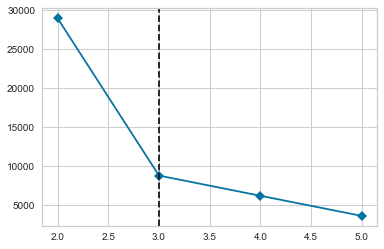

In [298]:
RAMDOM_SEED = 2048
dff_features = dff[features]
model = MiniBatchKMeans(init='k-means++', random_state=RAMDOM_SEED)
try:
  visualizer = KElbowVisualizer(model, k=(2,6), timings=False)
  visualizer.fit(dff_features)
  visualizer
except:
  pass

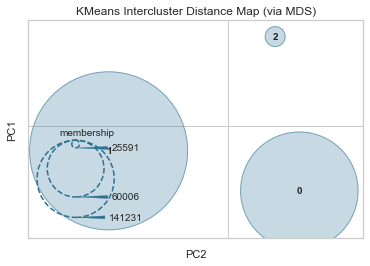

[ 60006 141231  25591]


In [305]:
model = KMeans(n_clusters=visualizer.elbow_value_, init='k-means++', random_state=RAMDOM_SEED)
model.fit(dff_features)
df['cluster']= model.predict(dff_features)

interDistance = InterclusterDistance(model, random_state=RAMDOM_SEED)
interDistance.fit(dff_features)
interDistance.show()

print(interDistance.scores_)

El efecto de estadarizar los features o no si cambia el comportamiento de los clusters, sin estandarizacion el grafico de distancia inter-cluster muestra un aparente overlaping estre casi todos los clusters. Si bien, este overlaping en dos dimenciones no es indicador de overlaping en las dimenciones reales, es un indicador de que la calidad de los clusters no es la mejor y que estan bastante cerca entre ellos.

Con la estadrizacion de las variables la cantidad de cluster recoemndada por Elbow method tambien cambio de 5 clusters a solo 3. Ahora, el graifco de inter-cluster distance muestra una mejora en la distribucion de los clusters los cuales estan mucho mas separados entre ellos.

In [ ]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.scatterplot(data=df, x='lat', y='long', hue='cluster').set(xlim=(-33.70, -33.1), ylim=(-70.4, -71))

In [309]:
for cluster in range(visualizer.elbow_value_):
  print('Cluster {} size: {}'.format(cluster, len(df[ df['cluster'] == cluster ][features])))
print(f'Feature used: {", ".join(features)}')

Cluster 0 size: 60006
Cluster 1 size: 141231
Cluster 2 size: 25591
Feature used: total_size, distance, delivery_type, lat, long, task_around, cost, delta


Text(0.5,0,'neighbording deliveries')

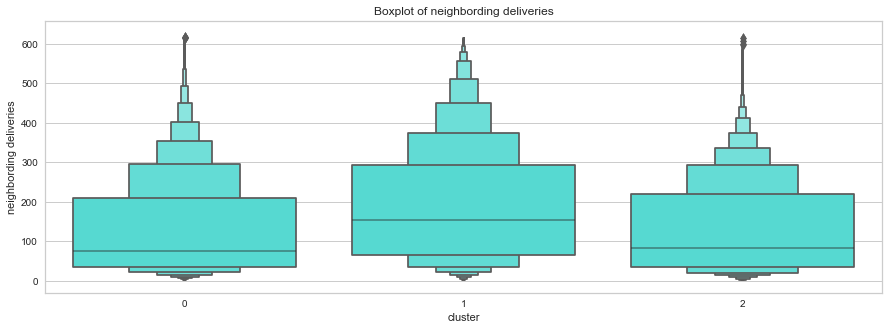

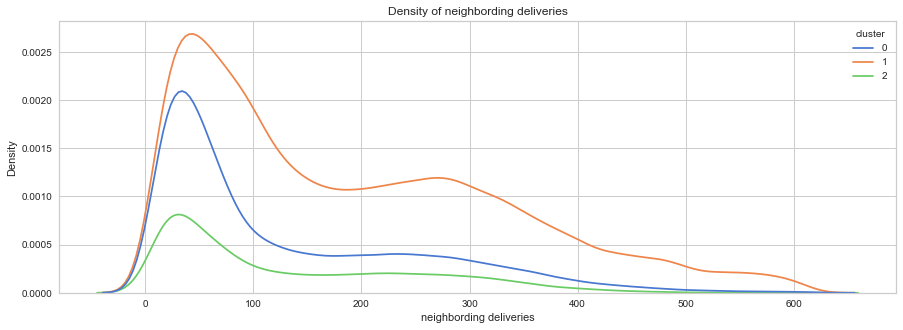

In [315]:
columns = ['total_size', 'distance', 'task_around']
df_ = remove_outlayers(df, 'task_around', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='task_around', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of neighbording deliveries')
gtg.set_ylabel('neighbording deliveries')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='task_around', hue='cluster', palette='muted')
gts.set_title('Density of neighbording deliveries')
gts.set_xlabel('neighbording deliveries')

In this graph is show a `boxenplot`. It is similar to a box plot in plotting a nonparametric representation of a distribution in which all features correspond to actual observations. By plotting more quantiles, it provides more information about the shape of the distribution, particularly in the tails.

En los boxplot podemos obsrevar que los clusters 0 y 2 mantienen una mediana muy similar, siendo la mas baja de los 2 clusters, con la diferencia de que en el cluster 0 contiene densidad de valores mas alta que el clsuters 0 en valores cercanos a 600 entregas vecinas. El clsuter 1 es quien tiene una mediana mas alta de los 3 clusters, con un rango tambien el mas amplio de los 3.

En el kdeplot podemos observar que la forma de las distribuciones es banstante similar entre los clusters, sin embargo, el cluster 1 es el que tiene un densidad mas alta de entregas vecinas que el reststo. El cluster 2 es el que menos densidad de tareas vecinas presenta.

Text(0.5,1,'Density of Neighbod deliveries')

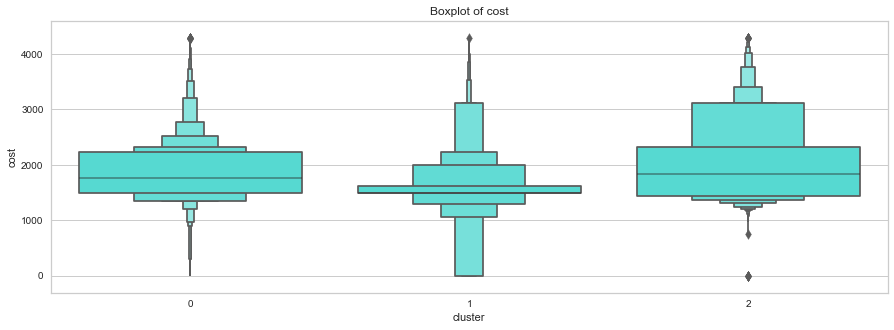

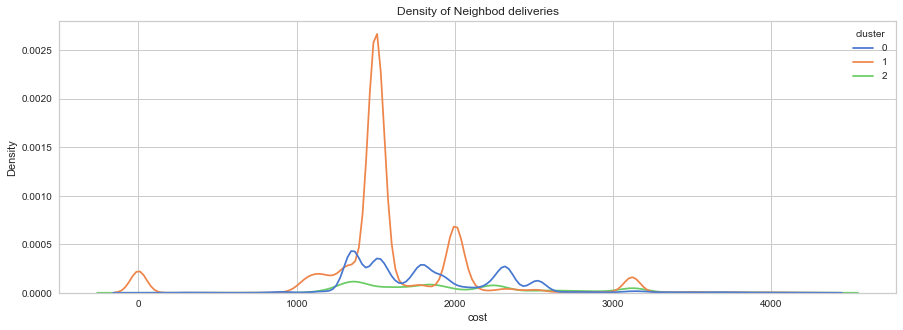

In [318]:
df_ = remove_outlayers(df, 'cost', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='cost', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of cost')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='cost', hue='cluster', palette='muted')
gts.set_title('Density of Neighbod deliveries')

En el boxplot podemos observar como entre el cluster 0 y 2 la mediana del costo para las entregas es similar entre ellos, siendo las mas alta de los 3 clusters. Sin embargo, el clsuter 2 tiene un rango de valores mucho mas amplio, llegando hasta los 4000 pesos chilenos con mas densidad de valores, el cluster 0 tiene un rango mas pequeño, entre 1200 y 2300 pesos chilenos. El cluster 1 es quien tiene la mediana mas pequeña y sus valores tienen una alta concentracion entorno a esa media, que es aprox 1400 pesos chilenos.

En el kdeplot podemos observar como claramente el clsuter 1 presenta una altisima densidad de tareas con un costo entre los valores de 100 y 200 dolares. El cluster 0 tiene pequeñas conncetraciones entre el rango de 100 y 2000 dolares, sin embargo, es mucho menos que el clsuter 1. Finalmente el cluster 2 es el que presenta la concentracion mas baja.

Text(0.5,1,'Density of distance')

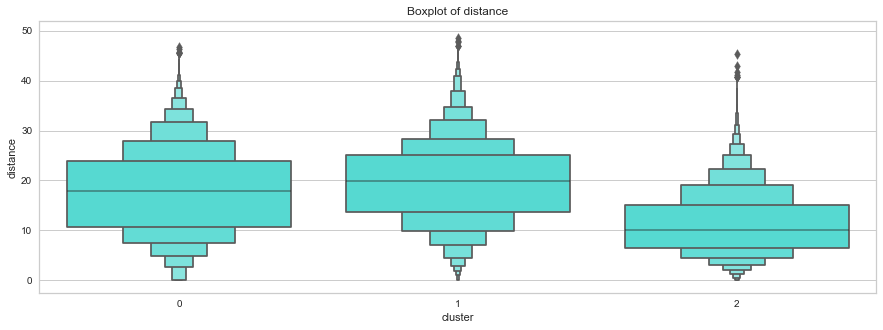

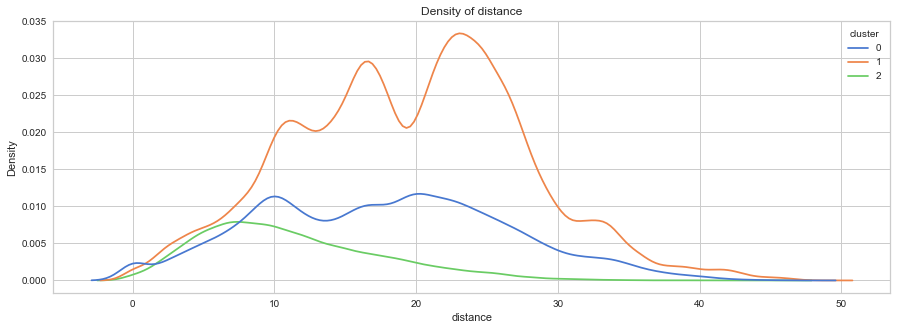

In [319]:
df_ = remove_outlayers(df, 'distance', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='distance', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of distance')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='distance', hue='cluster', palette='muted')
gts.set_title('Density of distance')

En los boxplot podemos observar que todas las medianas son diferentes, donde el cluster 2 es quien tiene la mediana mas vaja, es decir entregas con una distancia, en general, mas corta y su rango de valores es la mas estrecha de los 3 clusters. Luego le sigue el cluster 0, es quien tiene una mediana entre el cluster 1 y 2, con una distribución muy similar al cluster 1. Finalmente el cluster 1 es quien tiene la mediana mas alta, es decir, con entregas con una distancia mas larga y su distribucion tiene picos en los valores de 10, 15 y 20 km.

En el kdeplot, podmeos observar como el cluster 1 es el que presenta una densidad alta de entregas con distnacias entre 10 y 30 km, el cluster 0 tiene un comportamiento similar y por ultimo el cluster 2 tiene una conentracion mas alta entre los valores de 0 y 10 km.

Text(0.5,1,'Density of delta')

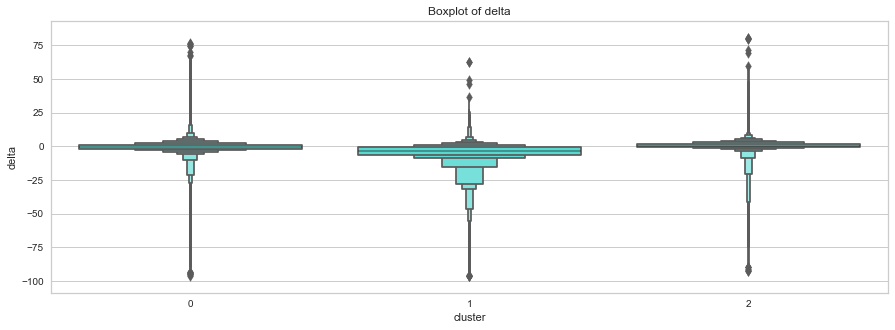

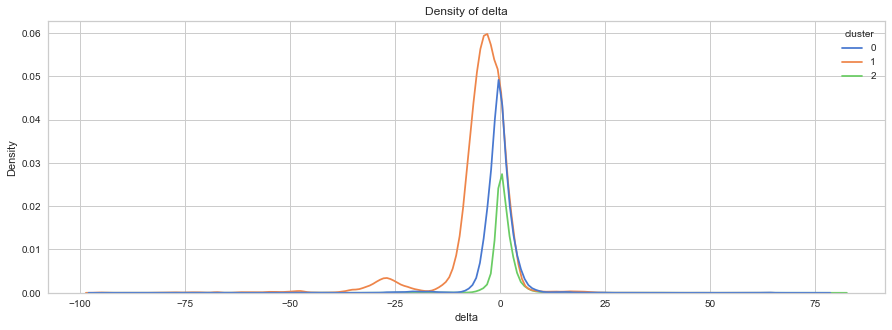

In [320]:
df_ = remove_outlayers(df, 'delta', True)

plt.figure(figsize=(15,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='delta', color=PALETTE_ALT[0])
gtg.set_title('Boxplot of delta')

plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='delta', hue='cluster', palette='muted')
gts.set_title('Density of delta')

En el boxplot y kdeplot podeos observar que el valor de delta es escalonado entre los clusters. El cluster 1 es quien tiene el valor de delta mas bajo, luego le sigue el clsuter 0 y por ultimo el cluster 2. Todos los clsuters tiene una distribucion bastante similar, muy estrecha entorno a la mediana.

## Cluster 0
- Tiene la mediana mas baja de entregas vecinas, junto con el clsuter 2.
- Tiene una media del costo mas alta junto con el cluster 2 pero con una distribucion mas estrecha entorno a ese valor de media.
- La distancia de sus entregas esta entre los valores de los cluster 1 y 2. Con un valor de 18 km.
- Tiene la mediana entre los valores de los cluster 1 y 2. Con un valor cercano a 0 horas.
## Cluster 1
- Mayor mediana de entregas vecinas de todos los clsuters.
- Menor costo en las entregas y su rango es muy renducido, entre 1200 y 1500 pesos chilenos.
- Mayor mediana de distancia de kms para sus entregas.
- La mediana de delta es la mas baja de los cluster, cercana a -5 horas, esto se interpreta como entregas que si llegaron antes de su hora teorica de entrega.
## Cluster 2
- Tiene la mediana mas baja de entregas vecinas, junto con el cluster 0.
- Tiene una mediana de costo mas alta junto con el cluster 0 pero con una distribucion mas amplia, llegando hasta valores de 4000 pesos chilenos.
- Tiene la media de distnacia mas baja de todos los clusters, con una alta concnetracion entorno a su media, aproximadamente a 50 pesos chilenos.
- Tiene la mediana de delta mas alta de los clusters, cercnaa a 5 horas, es decir contiene tareas atrasadas, pero con un atraso mucho mayor que el cluster 0.

## Resumen
El cluster 2 se pueden encontrar tareas con un delay con un delay de entrega mas alto de los clusters, una cantidad de entregas vecinas mas baja, costos altos y distancias cortas.

El cluster 1 se pueden encontrar tareas con un delay negativo es decir continee entregas que si llegan, generalmente, antes de su hora de entrega teorico, con una densidad de entregas vecinas mas alta, entregas mucho mas baratas  y una distancia mucho mas larga.
Tienen alta concentracion de vecinas, son mas distantes y en gneeral llegan atrasadas


El cluster 0 se pueden encontrar tareas con un delay cercana a 0, es decir contiene tanto tareas a tiempo como atrasadas, pero muy cercanas a 0 horas. Con tareas con pocas tareas vecinas, un costo mucho mas alto y una distancia entre los valores de los clusters 1 y 2.

In [ ]:
cluster_3 = df[ df['cluster'] == 3 ]
cluster_3[features].describe()

In [ ]:
cluster_1 = df[ df['cluster'] == 1 ]
cluster_2 = df[ df['cluster'] == 2 ]
cluster_3 = df[ df['cluster'] == 3 ]

## Josue Cobos

In [ ]:
g = sns.countplot(data=df_t, x='hight_neight', color=PALETTE_ALT[1])
g.set_xticks([0,1])

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delay?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [ ]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

In [ ]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delay_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [ ]:
subdf.corr()

In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.